In [1]:
import pandas as pd
import glob
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import statsmodels.api as sm


plt.style.use('fivethirtyeight')
plt.rcParams["figure.figsize"] = (20,12)

In [2]:
blue = '#30a2da'
red = '#fc4f30'

In [3]:
def replacenan(df):
    nans = df[df.Value < 10]['Value'].unique()
    for nan in nans:
        df.replace(nan, np.nan, inplace=True)
        

def fillnans(df):
    for date in np.unique(df[df['Value'].isna() == True].index.date):
        df[df.index.date == date] = df[df.index.date == date - dt.timedelta(days=366)].values #leap year
    return df

In [4]:
# Load Data - Kolding
path = r'../data/kolding/'
files = glob.glob(path + "/*.csv")

dfs = []

for file in files:
    df = pd.read_csv(file, index_col=None, header=0)
    dfs.append(df)

kld = pd.concat(dfs, axis=0, ignore_index=True)
kld.Datetime = pd.to_datetime(kld.Datetime)
kld = kld.groupby('Datetime').sum()

replacenan(kld)

kld = fillnans(kld)

In [5]:
# Load Data - Strib
path = r'../data/strib/'
files = glob.glob(path + "/*.csv")

dfs = []

for file in files:
    df = pd.read_csv(file, index_col=None, header=0)
    dfs.append(df)

stb = pd.concat(dfs, axis=0, ignore_index=True)
stb.Datetime = pd.to_datetime(stb.Datetime)
stb = stb.groupby('Datetime').sum()

replacenan(stb)

stb = fillnans(stb)

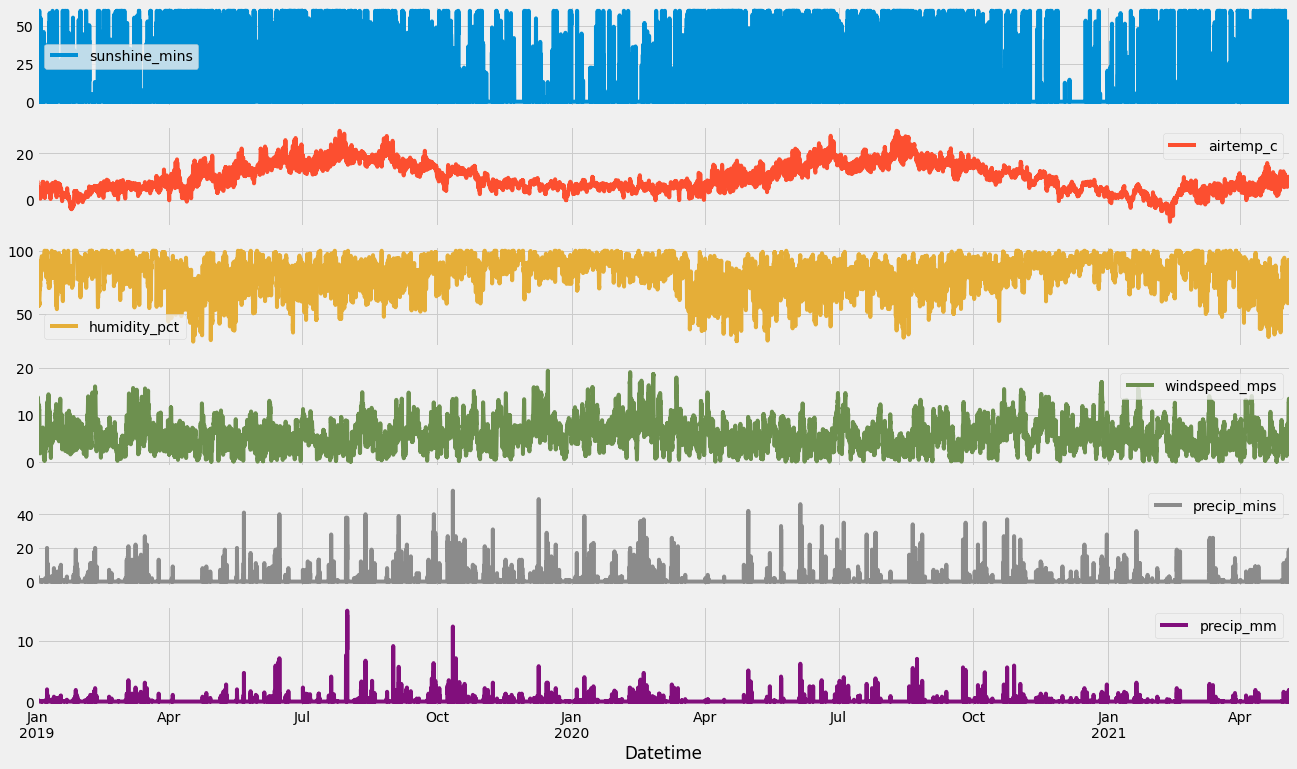

In [6]:
# Load Weather Data
weather = pd.read_csv('../data/weather_features.csv', header=0)
weather.Datetime = pd.to_datetime(weather.Datetime)
weather = weather.set_index('Datetime').sort_index()
weather.plot(subplots=True)
plt.show()

In [16]:
kld.describe().round(2).transpose()

,count,mean,std,min,25%,50%,75%,max
Value,20520.0,89.87,32.08,35.9,66.28,82.22,106.84,263.16


In [17]:
stb.describe().round(2).transpose()

,count,mean,std,min,25%,50%,75%,max
Value,20520.0,54.46,19.24,13.52,40.14,51.21,65.5,139.79


array([[<AxesSubplot:title={'center':'Value'}>]], dtype=object)

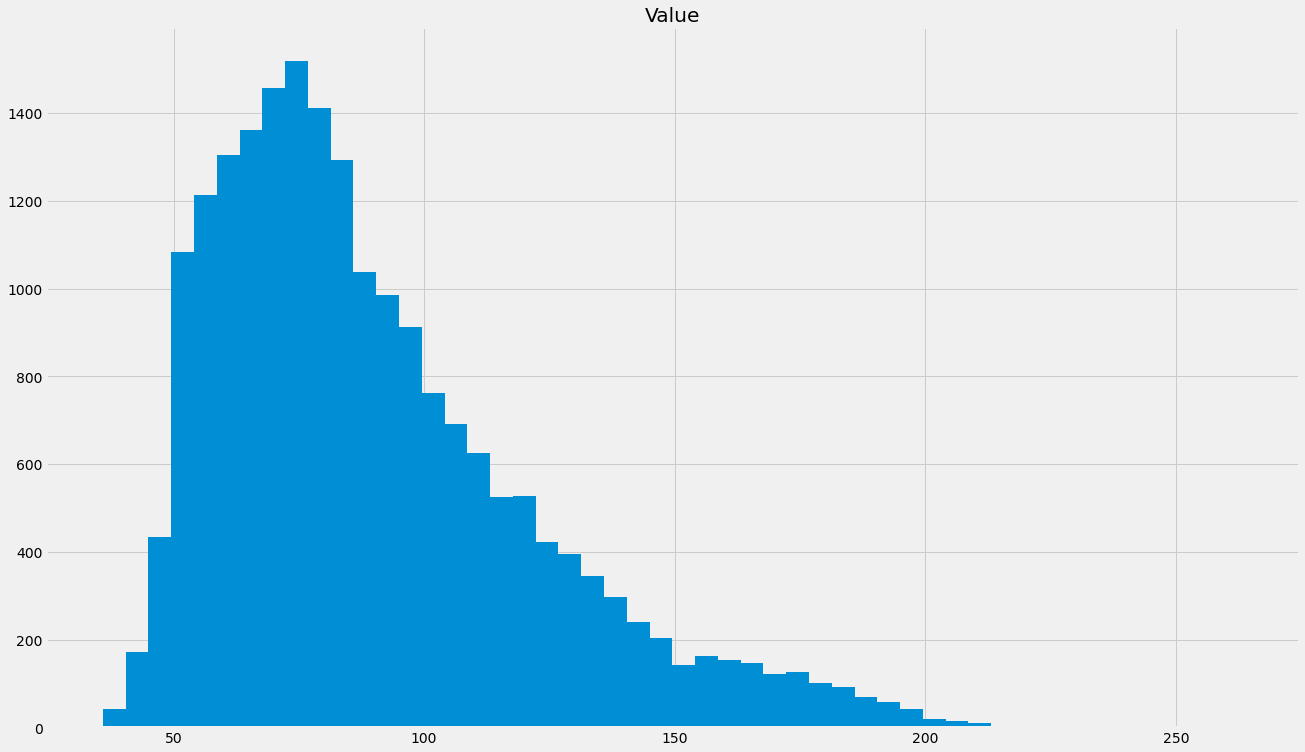

In [12]:
kld.hist(bins=50)

array([[<AxesSubplot:title={'center':'Value'}>]], dtype=object)

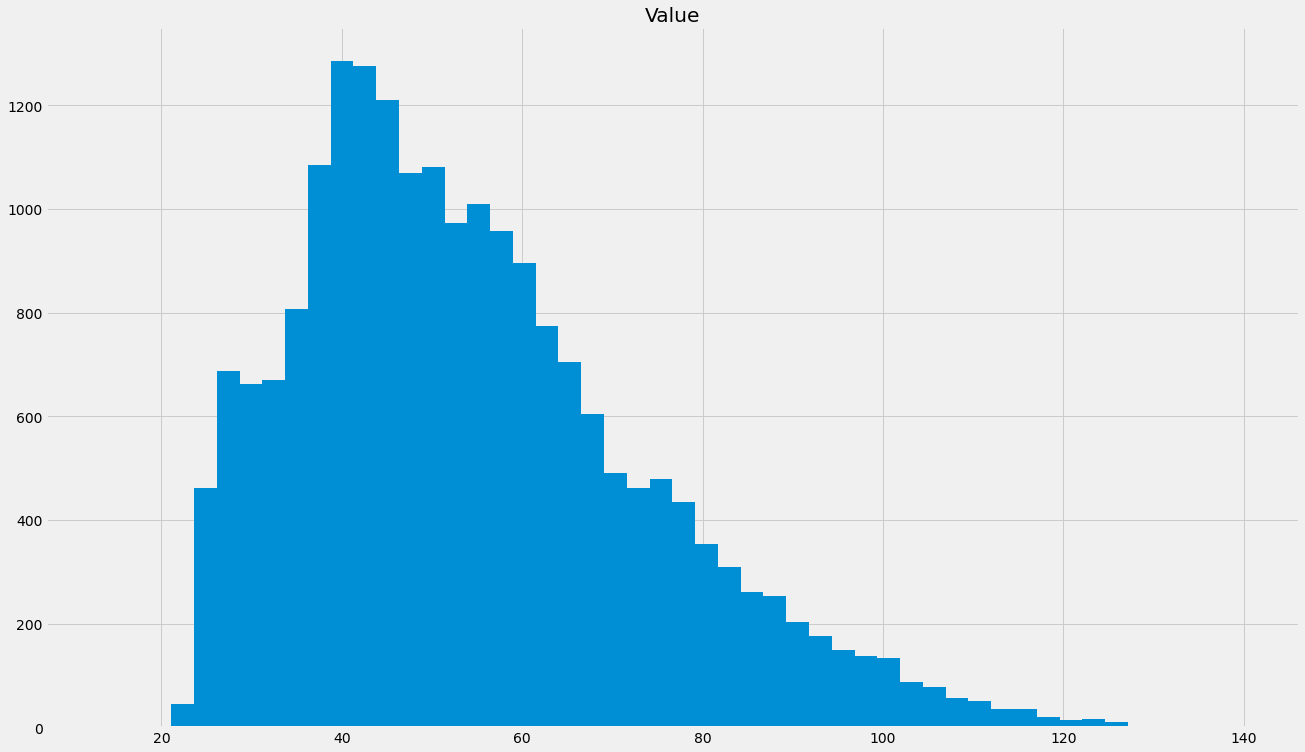

In [13]:
stb.hist(bins=50)

## Target Variable: Electricity Load

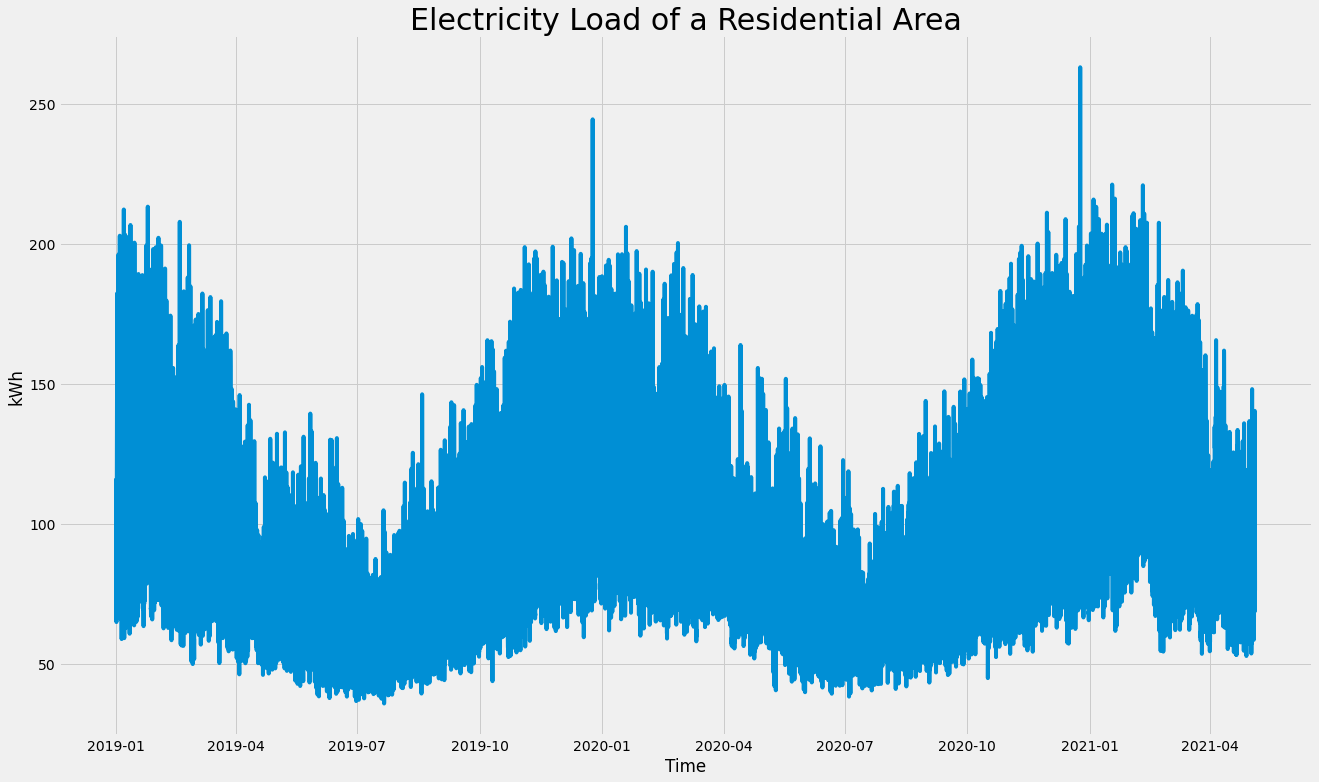

In [16]:
plt.figure()
plt.title('Electricity Load of a Residential Area', fontsize=30)
plt.xlabel('Time')
plt.ylabel('kWh')
plt.plot(kld)
plt.savefig('visuals/pres/load_feature.png', bbox_inches = "tight")
plt.show()

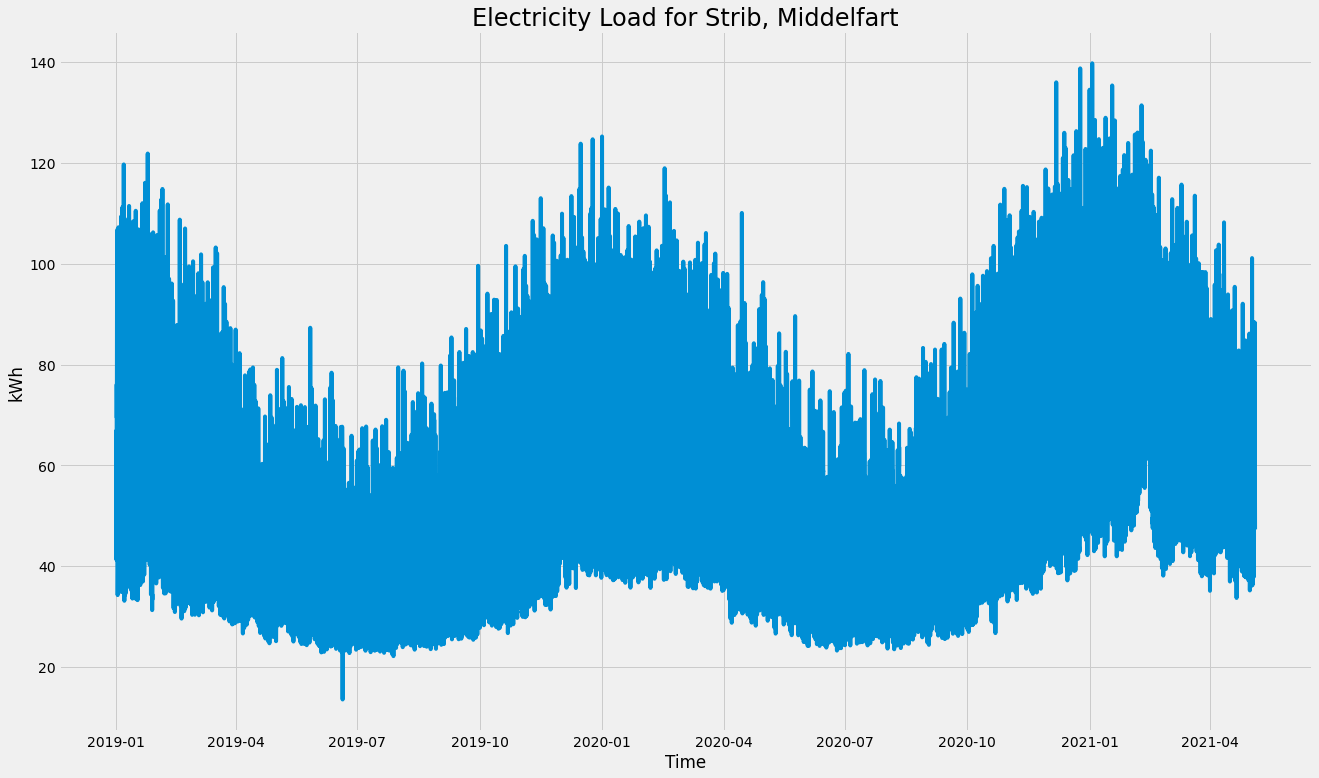

In [19]:
plt.figure()
plt.title('Electricity Load for Strib, Middelfart', fontsize=24)
plt.xlabel('Time')
plt.ylabel('kWh')
plt.plot(stb)
plt.savefig('visuals/load_feature_strib.png', bbox_inches = "tight")
plt.show()

Text(0.5, 0, 'Time')

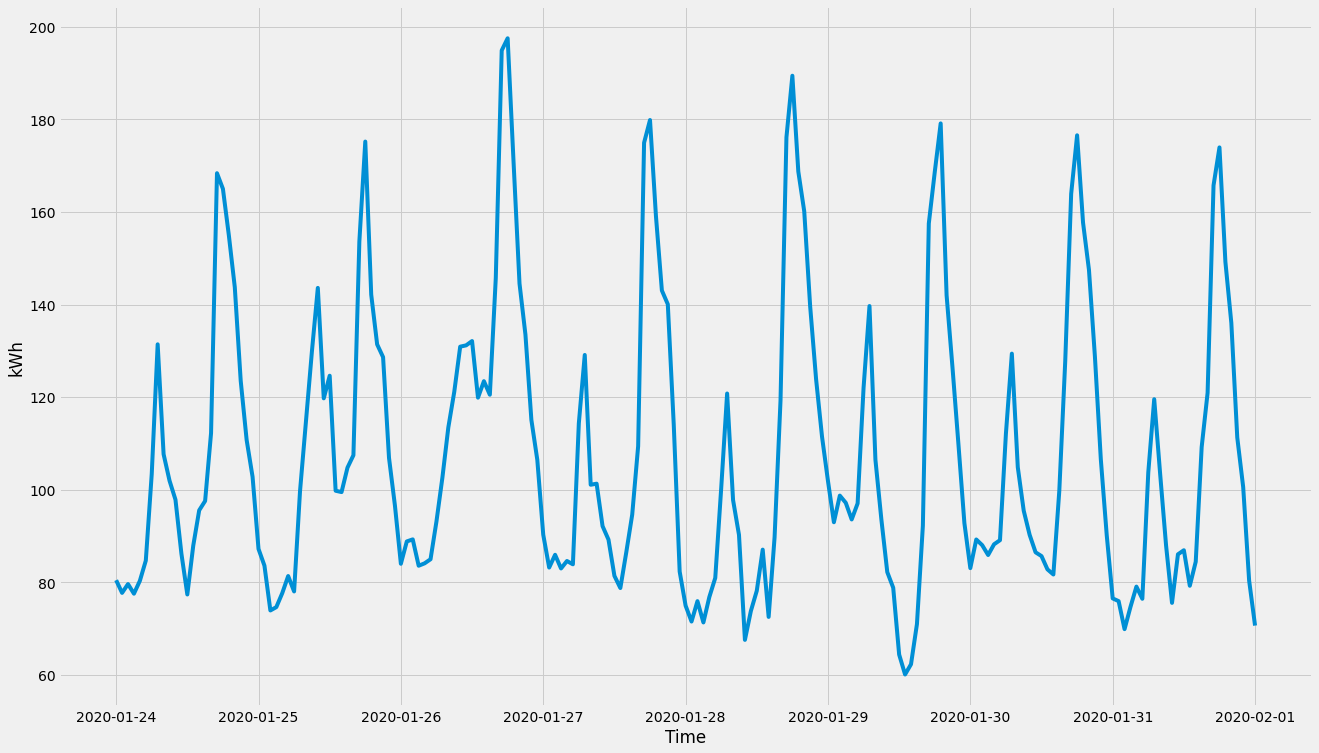

In [9]:
plt.title('', fontsize=24)
plt.plot(kld.loc[dt.date(2020, 1, 24):dt.date(2020,2,1)])
plt.ylabel('kWh')
plt.xlabel('Time')
plt.show()

## Seasonal Differences in Load Feature

In [7]:
jan19 = kld.loc[dt.date(2019, 1, 21):dt.date(2019, 1, 28)].values
aug19 = kld.loc[dt.date(2019, 8, 21):dt.date(2019, 8, 28)].values
jan20 = kld.loc[dt.date(2020, 1, 21):dt.date(2020, 1, 28)].values
aug20 = kld.loc[dt.date(2020, 8, 21):dt.date(2020, 8, 28)].values

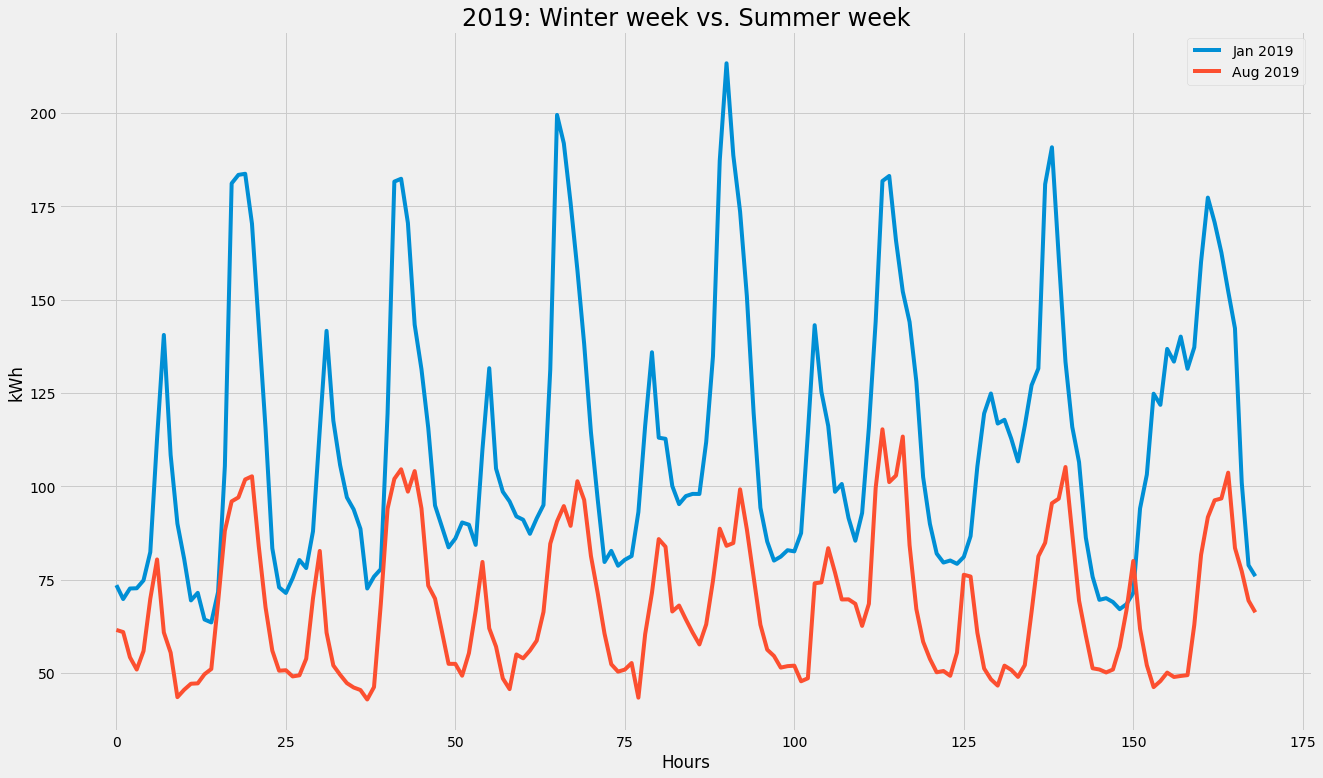

In [30]:
plt.title('2019: Winter week vs. Summer week', fontsize=24)
plt.plot(jan19, label='Jan 2019')
plt.plot(aug19, label='Aug 2019')
plt.ylabel('kWh')
plt.xlabel('Hours')
plt.legend()

plt.savefig('visuals/load_feature_winter_vs_summer.png', bbox_inches = "tight")
plt.show()

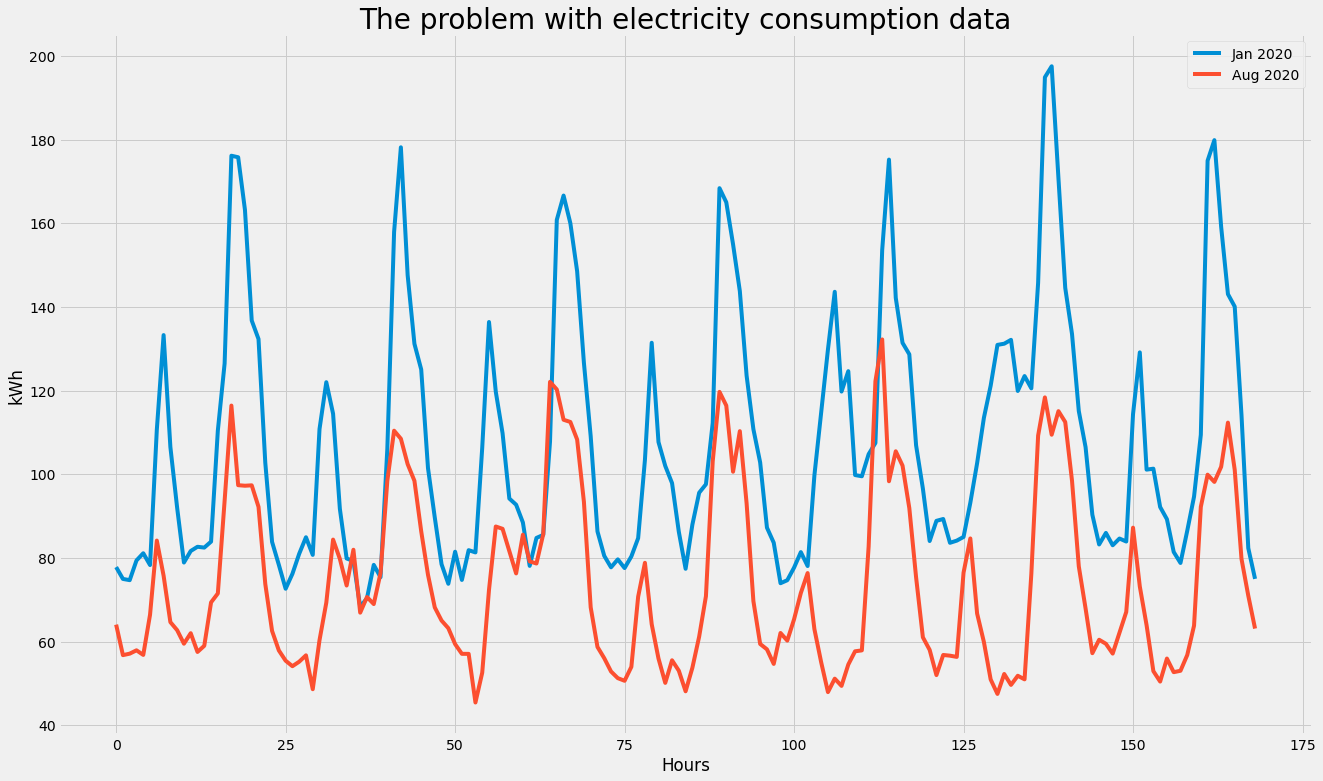

In [15]:
plt.title('The problem with electricity consumption data', fontsize=28)
plt.plot(jan20, label='Jan 2020')
plt.plot(aug20, label='Aug 2020')
plt.ylabel('kWh')
plt.xlabel('Hours')
plt.legend()
plt.savefig('visuals/pres/winter_vs_summer.png', bbox_inches = "tight")

plt.show()

## Feature Variable: Sunshine minutes last hour
  
  
The assumption to use this feature as a valuable feature to extract some behavioral patterns in the load value is based on trend that more sunshine decreases the energy consumed.

In [57]:
weather[['sunshine_mins']].describe().round(2).transpose()

,count,mean,std,min,25%,50%,75%,max
sunshine_mins,20520.0,12.53,21.52,0.0,0.0,0.0,18.0,60.0


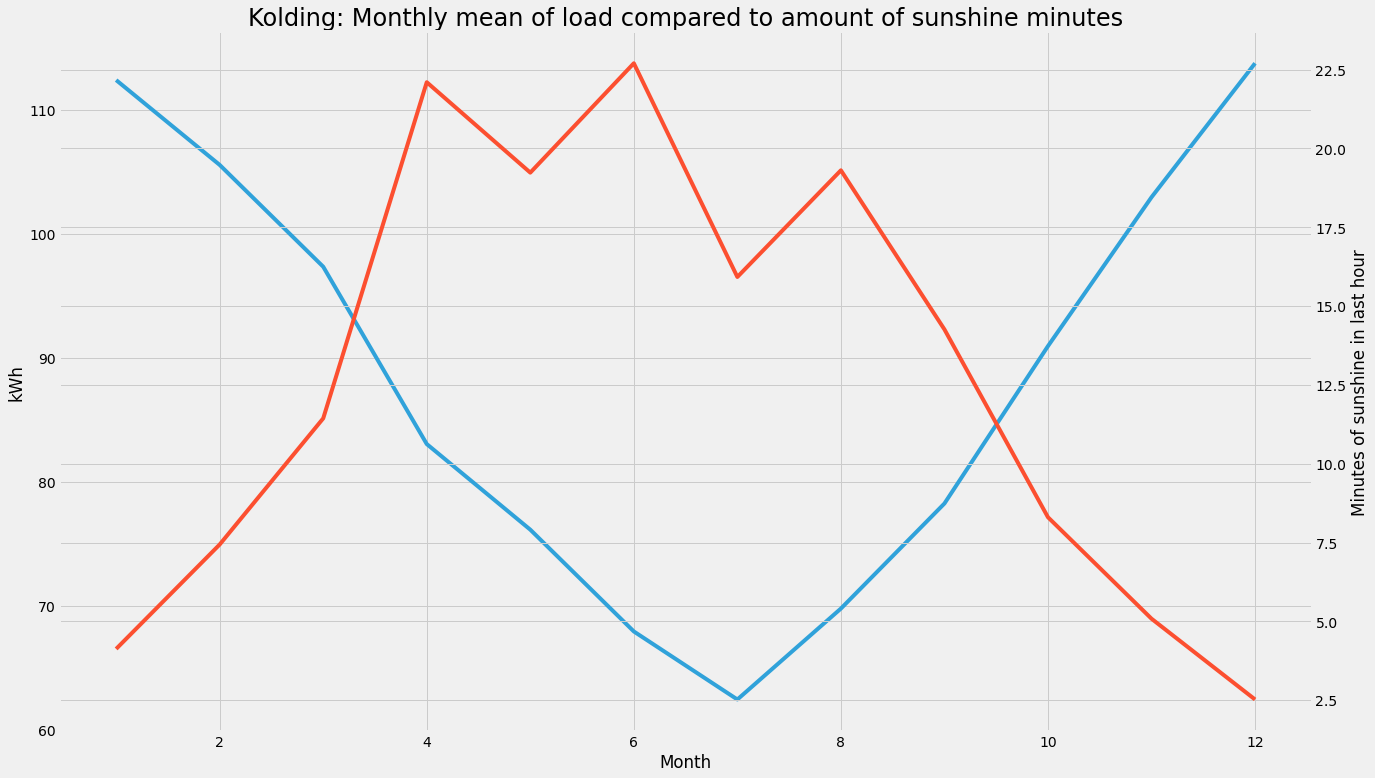

In [44]:
idx_mth = kld.index.month
mean_load_monthly = kld.groupby(idx_mth).mean()
mean_sunshine_monthly = weather.groupby(idx_mth).mean()

fig, ax1 = plt.subplots()
plt.title('Kolding: Monthly mean of load compared to amount of sunshine minutes', fontsize=24)

ax1.set_xlabel('Month')
ax1.set_ylabel('kWh')
ax1.plot(mean_load_monthly, color=blue)


ax2 = ax1.twinx()
ax2.set_ylabel('Minutes of sunshine in last hour')
ax2.plot(mean_sunshine_monthly['sunshine_mins'], color=red)


plt.savefig('visuals/sunshine_feature_monthlymean.png', bbox_inches = "tight")
plt.show()

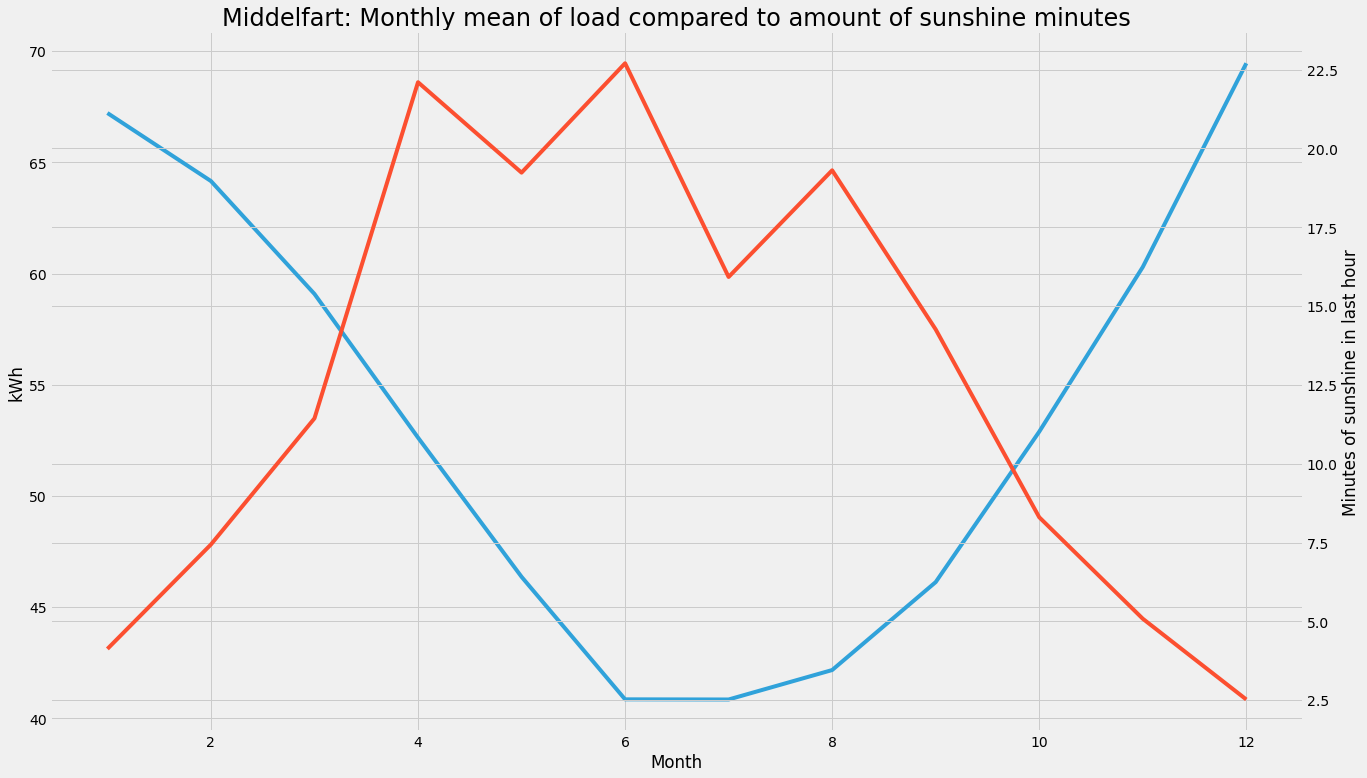

In [15]:
idx_mth = stb.index.month
mean_load_monthly = stb.groupby(idx_mth).mean()
mean_sunshine_monthly = weather.groupby(idx_mth).mean()

fig, ax1 = plt.subplots()
plt.title('Middelfart: Monthly mean of load compared to amount of sunshine minutes', fontsize=24)

ax1.set_xlabel('Month')
ax1.set_ylabel('kWh')
ax1.plot(mean_load_monthly, color=blue)

ax2 = ax1.twinx()
ax2.set_ylabel('Minutes of sunshine in last hour')
ax2.plot(mean_sunshine_monthly['sunshine_mins'], color=red)

plt.savefig('visuals/sunshine_feature_monthlymean_strib.png', bbox_inches = "tight")
plt.show()

The above graphs give an indication of negatively correlated features. As the mean electricity value decreases during summer months, the amount of sunshine minutes increases. Using the sunshine minutes feature can give some more context to the data and hopefully extract meaningful patterns that help the prediction. 

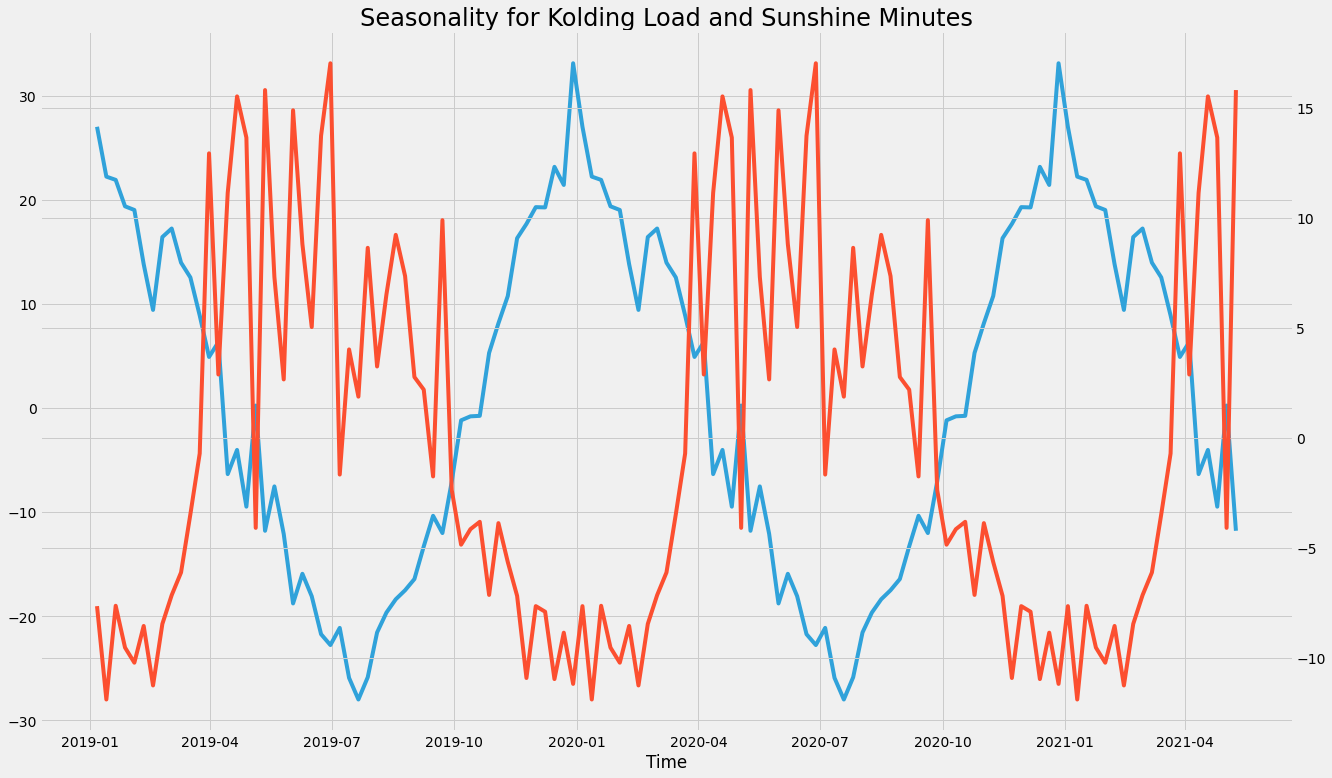

In [46]:
# Seasonality (resampled to weekly to make graph less noisy)
weekly_load = kld.resample('W').mean()
weekly_sunshine = weather['sunshine_mins'].resample('W').mean()

decomp_load = sm.tsa.seasonal_decompose(weekly_load)
decomp_sunshine = sm.tsa.seasonal_decompose(weekly_sunshine)

fig, ax1 = plt.subplots()
plt.title('Seasonality for Kolding Load and Sunshine Minutes', fontsize=24)

ax1.set_xlabel('Time')
ax1.set_ylabel('')
ax1.plot(decomp_load.seasonal, color=blue)

ax2 = ax1.twinx()
ax2.set_ylabel('')
ax2.plot(decomp_sunshine.seasonal, color=red)

plt.show()

## Feature Variable: Dry Air Temperature
  
  
The dry air temperature is used to extract information about the behavioral patterns of residents. I assume that a higher temperature means that people spend more time outside of their home than during colder periods, where they would rather stay inside, and in turn, consume more electricity.

In [58]:
weather[['airtemp_c']].describe().round(2).transpose()

,count,mean,std,min,25%,50%,75%,max
airtemp_c,20520.0,9.46,6.04,-9.42,5.0,8.03,14.17,29.57


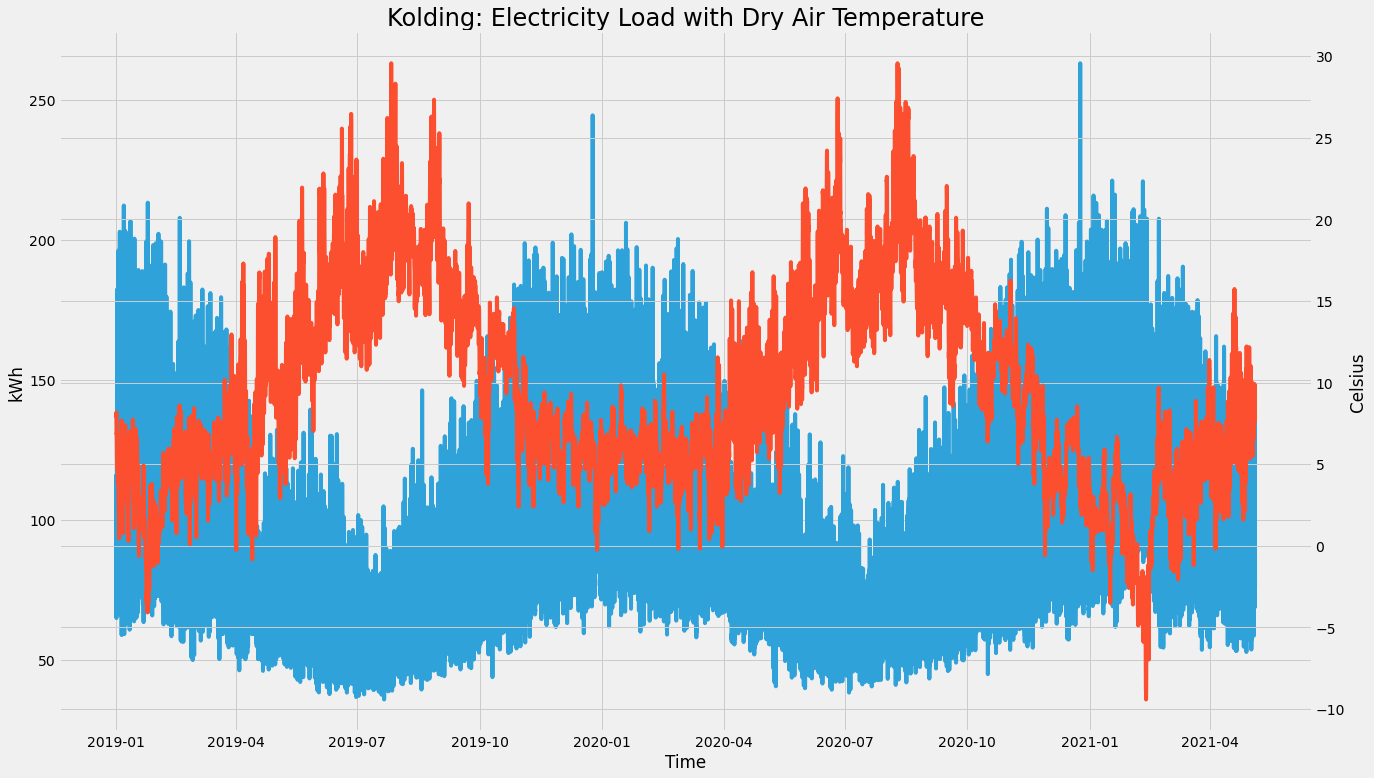

In [47]:
fig, ax1 = plt.subplots()
plt.title('Kolding: Electricity Load with Dry Air Temperature', fontsize=24)

ax1.set_xlabel('Time')
ax1.set_ylabel('kWh')
ax1.plot(kld, color=blue, label='Load')


ax2 = ax1.twinx()
ax2.set_ylabel('Celsius')
ax2.plot(weather['airtemp_c'], color=red, label='Air Temperature')



plt.savefig('visuals/temp_feature_pattern.png', bbox_inches = "tight")
plt.show()

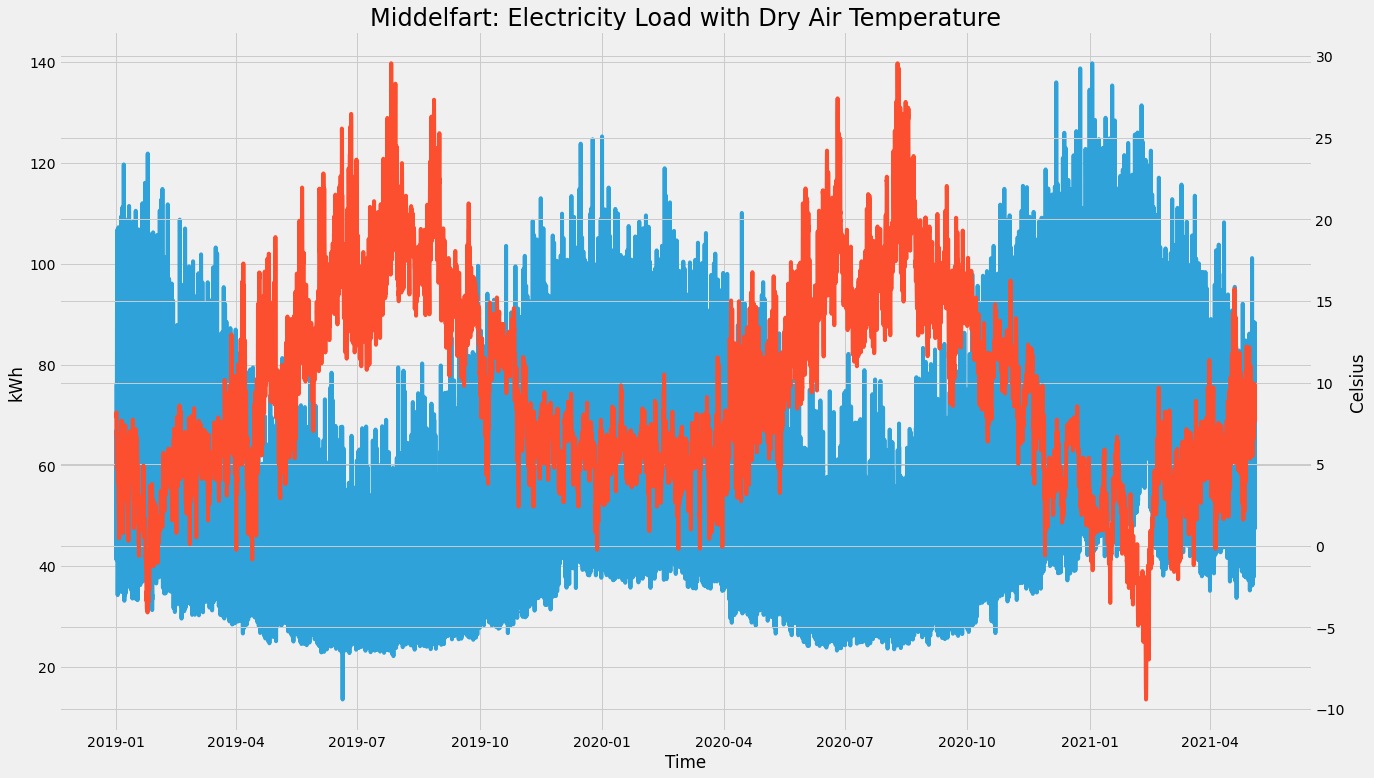

In [16]:
fig, ax1 = plt.subplots()
plt.title('Middelfart: Electricity Load with Dry Air Temperature', fontsize=24)

ax1.set_xlabel('Time')
ax1.set_ylabel('kWh')
ax1.plot(stb, color=blue)

ax2 = ax1.twinx()
ax2.set_ylabel('Celsius')
ax2.plot(weather['airtemp_c'], color=red)

plt.savefig('visuals/temp_feature_pattern_strib.png', bbox_inches = "tight")
plt.show()

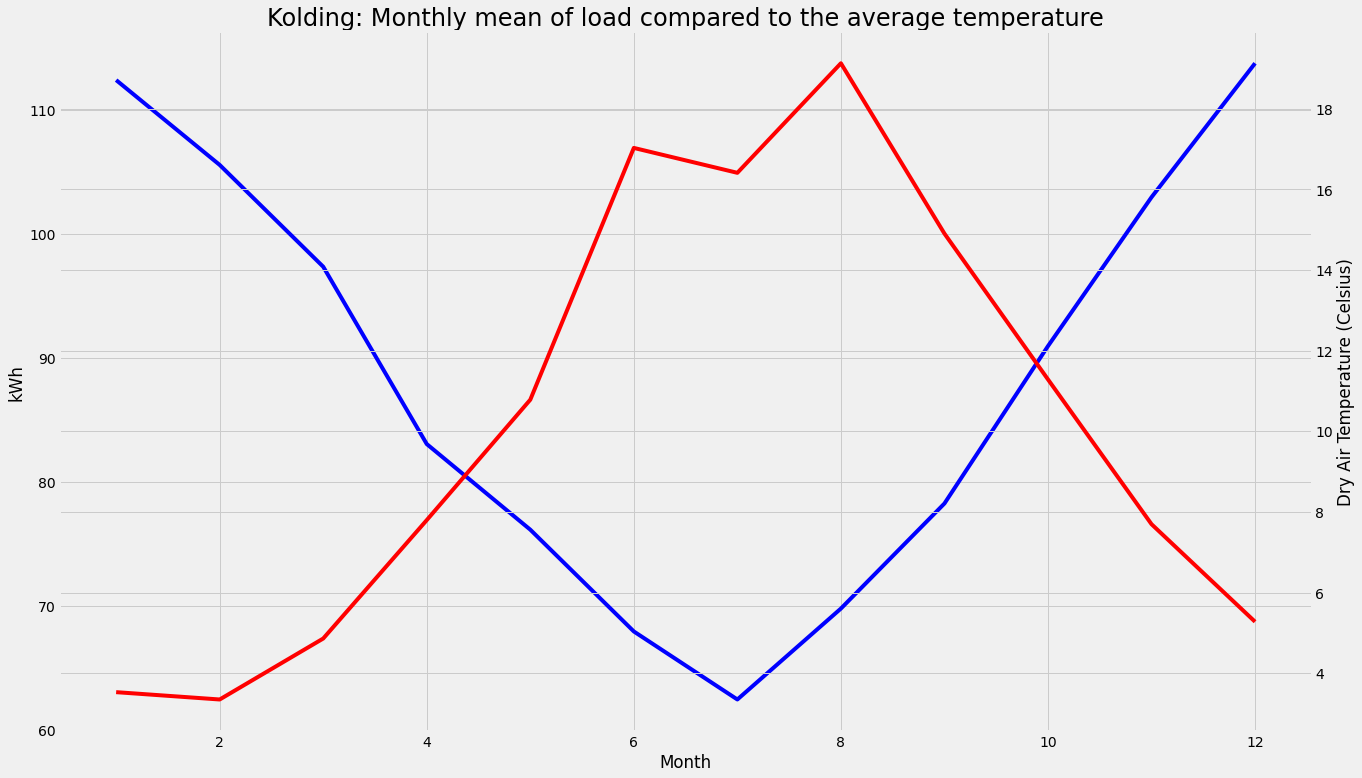

In [16]:
idx_mth = kld.index.month
mean_load_monthly = kld.groupby(idx_mth).mean()
mean_temp_monthly = weather.groupby(idx_mth).mean()

fig, ax1 = plt.subplots()
plt.title('Kolding: Monthly mean of load compared to the average temperature', fontsize=24)

ax1.set_xlabel('Month')
ax1.set_ylabel('kWh')
ax1.plot(mean_load_monthly, color='blue')

ax2 = ax1.twinx()
ax2.set_ylabel('Dry Air Temperature (Celsius)')
ax2.plot(mean_temp_monthly['airtemp_c'], color='red')

plt.show()

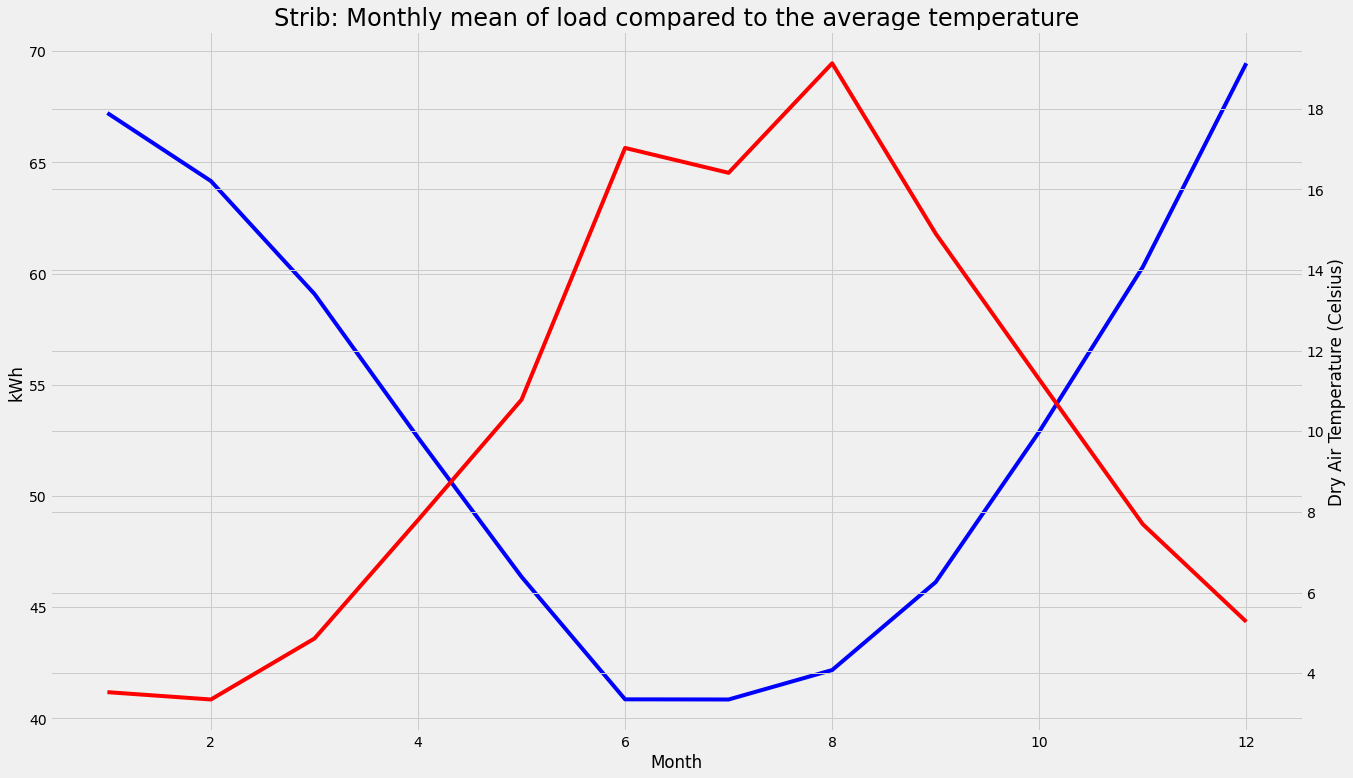

In [29]:
idx_mth = stb.index.month
mean_load_monthly = stb.groupby(idx_mth).mean()
mean_temp_monthly = weather.groupby(idx_mth).mean()

fig, ax1 = plt.subplots()
plt.title('Strib: Monthly mean of load compared to the average temperature', fontsize=24)

ax1.set_xlabel('Month')
ax1.set_ylabel('kWh')
ax1.plot(mean_load_monthly, color='blue')

ax2 = ax1.twinx()
ax2.set_ylabel('Dry Air Temperature (Celsius)')
ax2.plot(mean_temp_monthly['airtemp_c'], color='red')

plt.show()

## Feature Variable: Daylength
  
  
Using daylengths I aim to extract further seasonal patterns within the data. The trend in electricity consumption shows that winter months have much higher average consumption than summer months. Thus, daylength gives a good idea of when people are inside consuming electricity, rather than outside their homes.

In [50]:
daylengths = pd.read_csv('../data/daylengths.csv').transpose().iloc[1:]
daylengths.reset_index(inplace=True)
daylengths.columns = ['date', 'daylength_hrs']

daylengths['date'] = daylengths['date'].apply(lambda row: row[1:])
daylengths['date'] = pd.to_datetime(daylengths['date'], format='%Y.%m.%d')

daylengths.set_index('date', inplace=True)

In [59]:
daylengths.describe().round(2).transpose()

,count,mean,std,min,25%,50%,75%,max
daylength_hrs,855.0,12.11,3.45,7.04,8.87,12.03,15.23,17.51


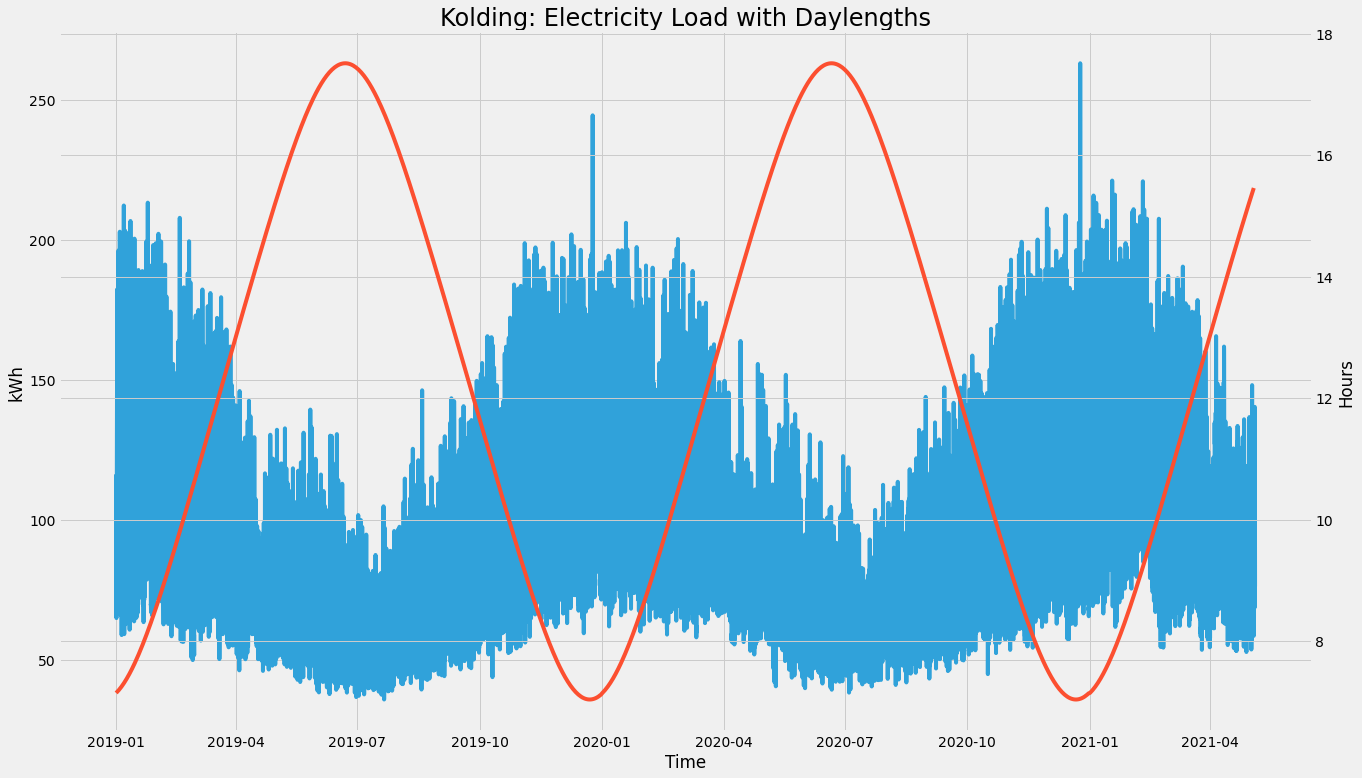

In [52]:
fig, ax1 = plt.subplots()
plt.title('Kolding: Electricity Load with Daylengths', fontsize=24)

ax1.set_xlabel('Time')
ax1.set_ylabel('kWh')
ax1.plot(kld, color=blue)

ax2 = ax1.twinx()
ax2.set_ylabel('Hours')
ax2.plot(daylengths, color=red)

plt.savefig('visuals/daylength_feature_pattern.png', bbox_inches = "tight")
plt.show()

## Feature Variable: Weekdays

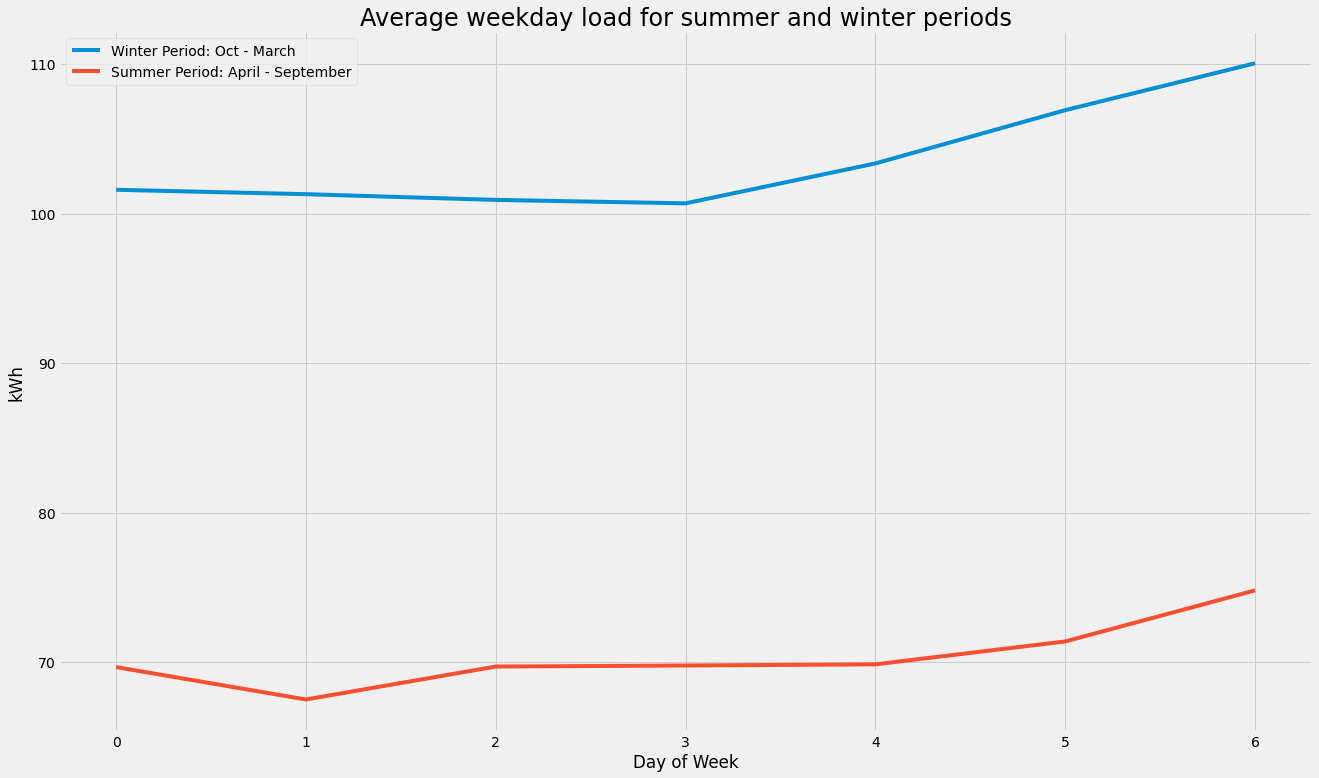

In [61]:
summer_period = kld.loc[dt.date(2019, 4, 1):dt.date(2019, 10, 1)][:-1]
winter_period = kld.loc[dt.date(2019, 10, 1):dt.date(2020, 4, 1)][:-1]

dow_summer = summer_period.index.dayofweek
dow_winter = winter_period.index.dayofweek

mean_summer = summer_period.groupby(dow_summer).mean()
mean_winter = winter_period.groupby(dow_winter).mean()

plt.plot(mean_winter, label='Winter Period: Oct - March')
plt.plot(mean_summer, label='Summer Period: April - September')
plt.title('Average weekday load for summer and winter periods', fontsize=24)
plt.xlabel('Day of Week')
plt.ylabel('kWh')
plt.legend()

plt.savefig('visuals/weekday_feature_summer_vs_winter.png', bbox_inches = "tight")
plt.show()

## Feature Variable: Weekends

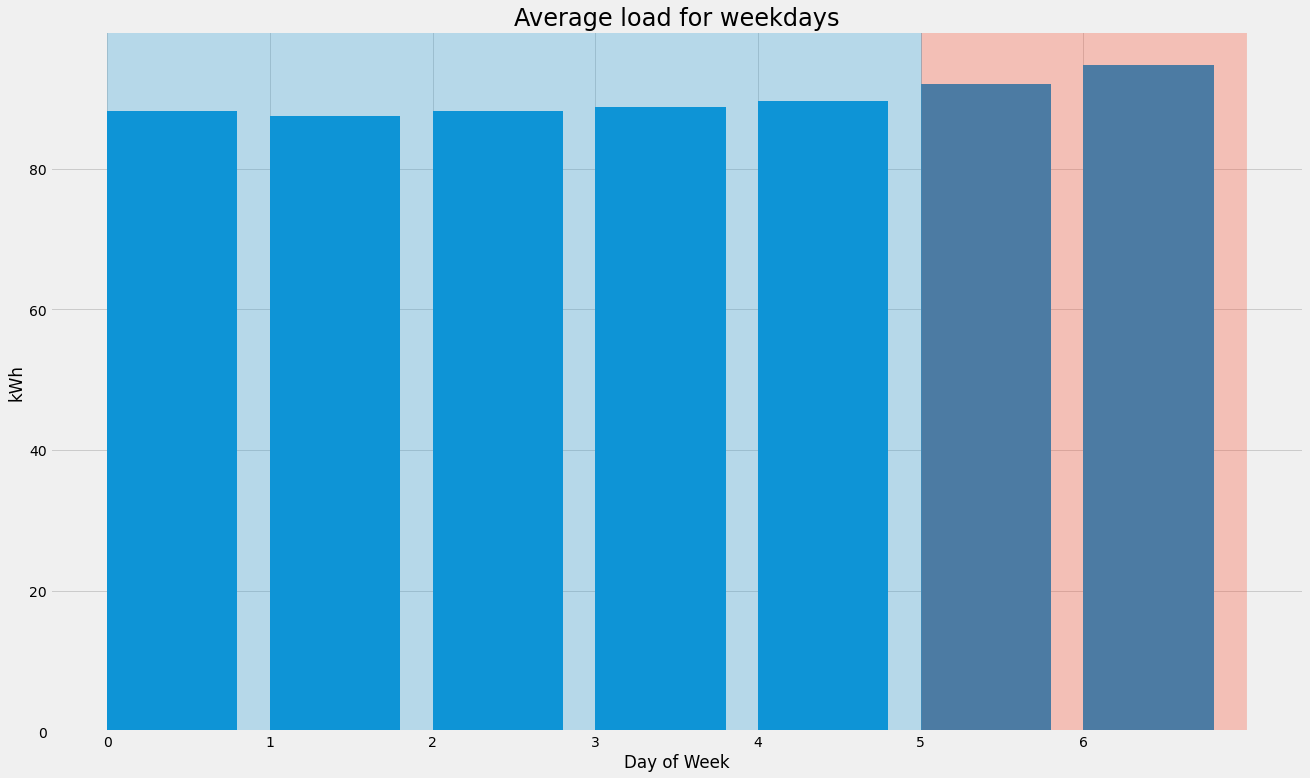

In [63]:
idx_dow = kld.index.dayofweek
mean_load_dow = kld.groupby(idx_dow).mean()
xs = [str(val) for val in mean_load_dow.index.tolist()]
ys = [val[0] for val in mean_load_dow.values]

plt.bar(x=xs, height=ys, align='edge')
plt.title('Average load for weekdays', fontsize=24)
plt.xlabel('Day of Week')
plt.ylabel('kWh')
plt.axvspan(5,7, color=red, alpha=.3)
plt.axvspan(0,5, color=blue, alpha=.3)
plt.show()

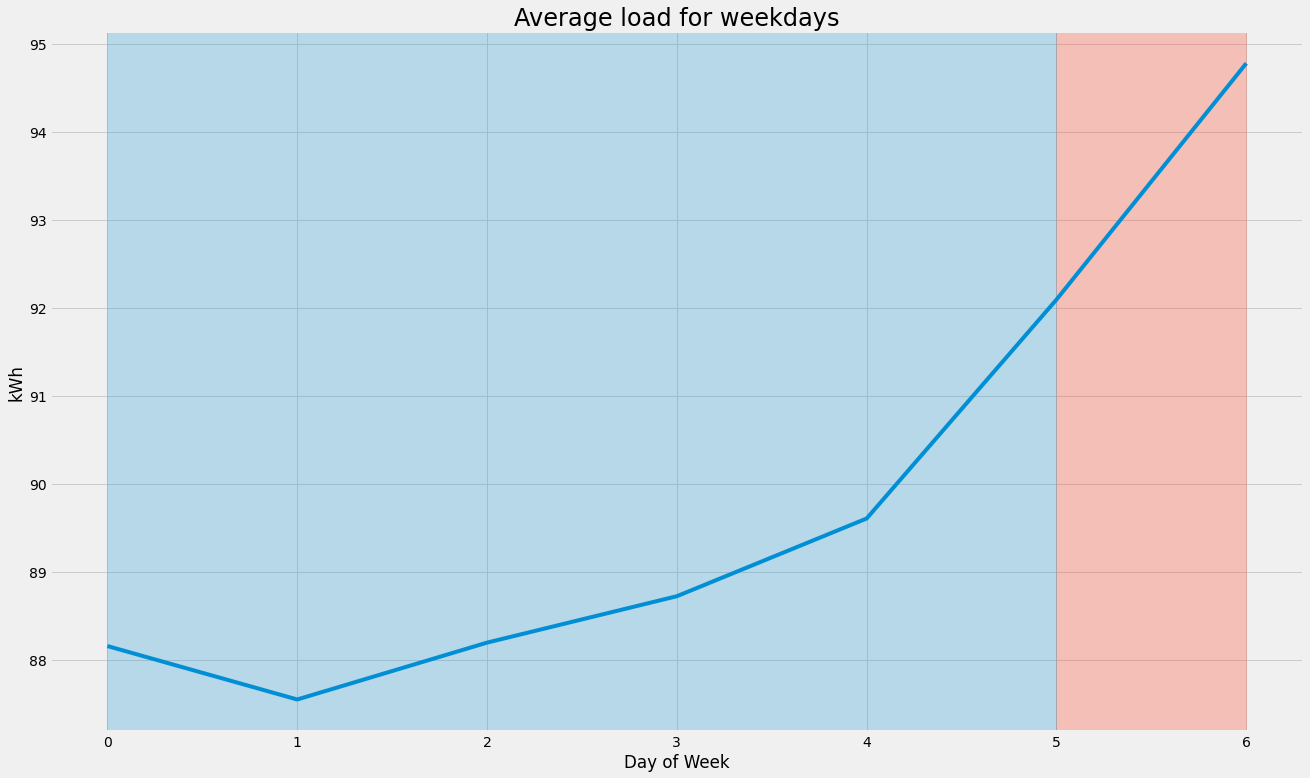

In [66]:
idx_dow = kld.index.dayofweek
mean_load_dow = kld.groupby(idx_dow).mean()


plt.plot(mean_load_dow)
plt.title('Average load for weekdays', fontsize=24)
plt.xlabel('Day of Week')
plt.ylabel('kWh')
plt.axvspan(5,6, color=red, alpha=.3)
plt.axvspan(0,5, color=blue, alpha=.3)
plt.savefig('visuals/weekend_feature_avg_load.png', bbox_inches = "tight")
plt.show()

## Feature Variable: Month

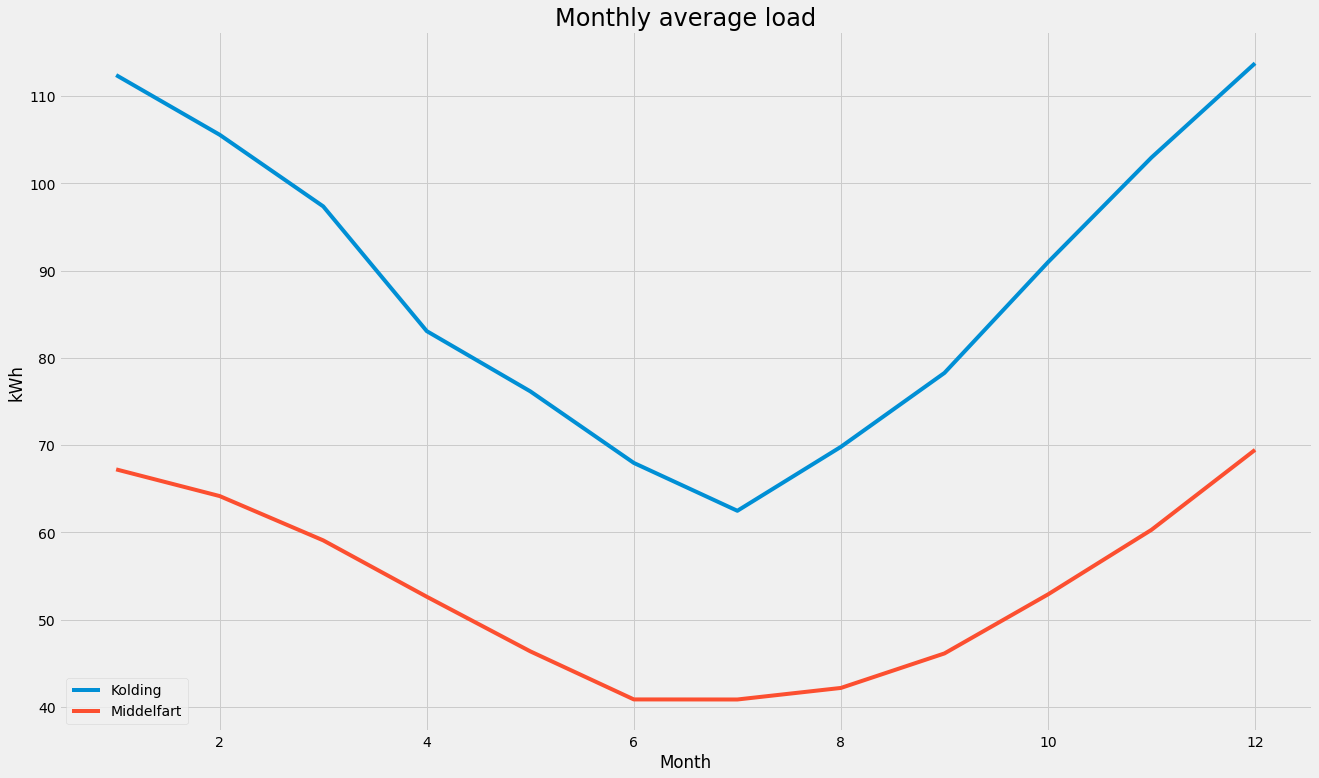

In [70]:
idx_mth = kld.index.month
mean_load_mth = kld.groupby(idx_mth).mean()


plt.plot(mean_load_mth, label='Kolding')
idx_mth = stb.index.month
mean_load_mth = stb.groupby(idx_mth).mean()


plt.plot(mean_load_mth, label='Middelfart')
plt.title('Monthly average load', fontsize=24)
plt.xlabel('Month')
plt.ylabel('kWh')
plt.legend()
plt.savefig('visuals/month_feature_avg_load.png', bbox_inches='tight')
plt.show()

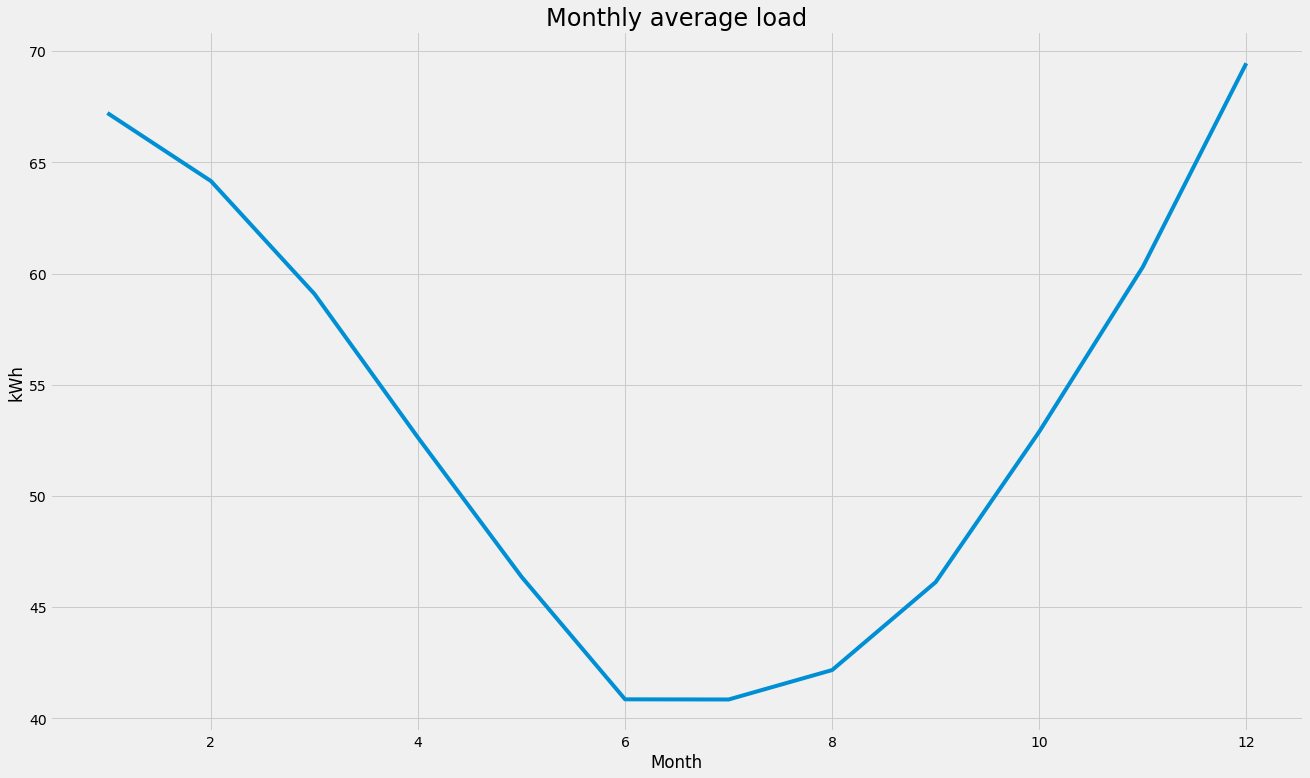

In [113]:
idx_mth = stb.index.month
mean_load_mth = stb.groupby(idx_mth).mean()


plt.plot(mean_load_mth)
plt.title('Monthly average load', fontsize=24)
plt.xlabel('Month')
plt.ylabel('kWh')
plt.show()

## Correlations

In [1]:
import seaborn as sns

In [4]:
features = pd.read_csv('../data/processed/kolding_features.csv', index_col='Datetime', parse_dates=['Datetime'])
features = features[['Value', 'sunshine_mins', 'airtemp_c', 'daylength_hrs']]

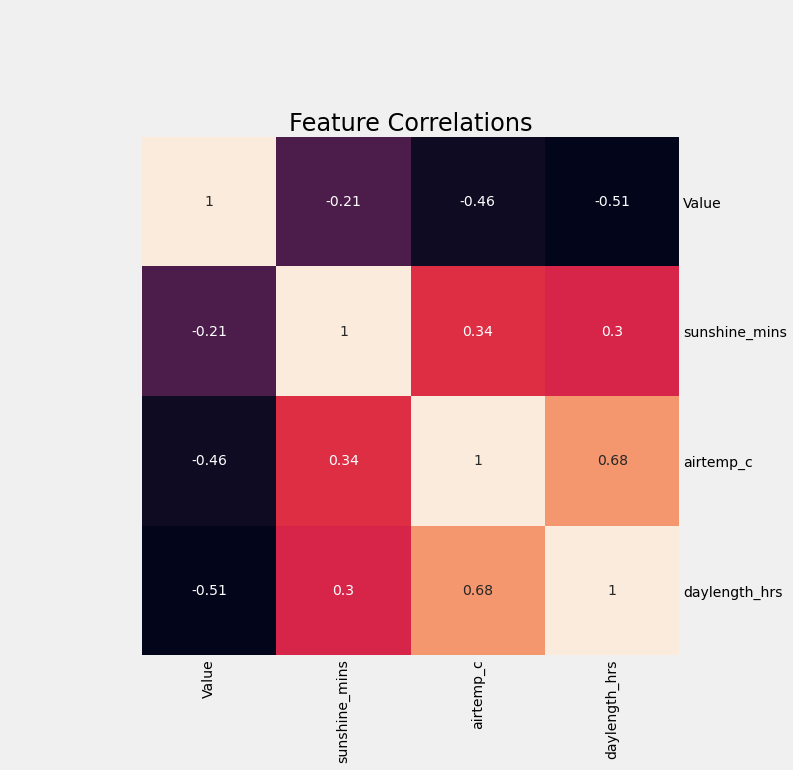

In [5]:
corr_feats = features.corr(method='pearson')

fig = sns.clustermap(corr_feats,annot=True,row_cluster=False, col_cluster=False, cbar_pos=None)
plt.title('Feature Correlations', fontsize=24)
plt.setp(fig.ax_heatmap.xaxis.get_majorticklabels(), rotation=90)
plt.setp(fig.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.savefig('visuals/correlations_features.png', bbox_inches = "tight")
plt.show()


In [79]:
decomps = {}

feature_names = features.columns

for ts in feature_names:
    ts_decomp = sm.tsa.seasonal_decompose(features[ts])
    decomps[ts] = ts_decomp

ts_seasonal = {}
    
for ts in feature_names:
    ts_seasonal[ts] = decomps[ts].seasonal
    
seasonality_df = pd.DataFrame.from_dict(ts_seasonal)

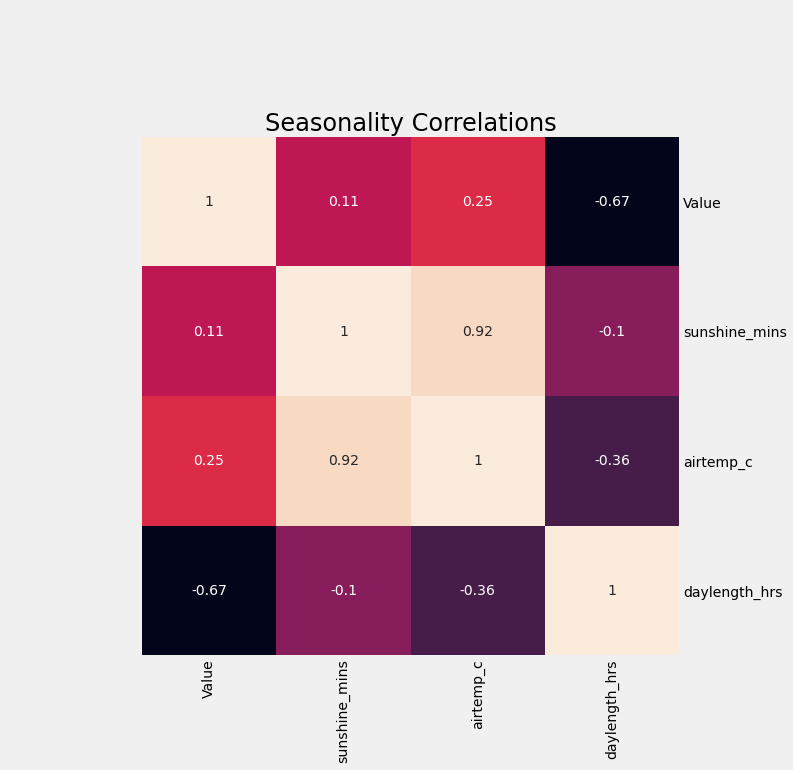

In [85]:
seasonality_corr = seasonality_df.corr(method='pearson')

fig = sns.clustermap(seasonality_corr, annot=True,row_cluster=False, col_cluster=False, cbar_pos=None)
plt.title('Seasonality Correlations', fontsize=24)
plt.setp(fig.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.setp(fig.ax_heatmap.xaxis.get_majorticklabels(), rotation=90)
plt.savefig('visuals/correlations_seasonality.png', bbox_inches = "tight")
plt.show()